## Challenge
### life expectancy

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox
from sklearn.preprocessing import normalize

warnings.filterwarnings('ignore')

### Upload data from sql

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

### What Are we trying to solve?

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

### An Examination of the Data Structure & Missing Values

In [3]:
lifeexpectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

### Any missing data?

Population has the greatest number of missing values followed by Hep B, and total expenditure. 

In [5]:
lifeexpectancy_df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [6]:
#by percentage

lifeexpectancy_df.isnull().sum()*100/lifeexpectancy_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

#### Visual Representation of Missing Data

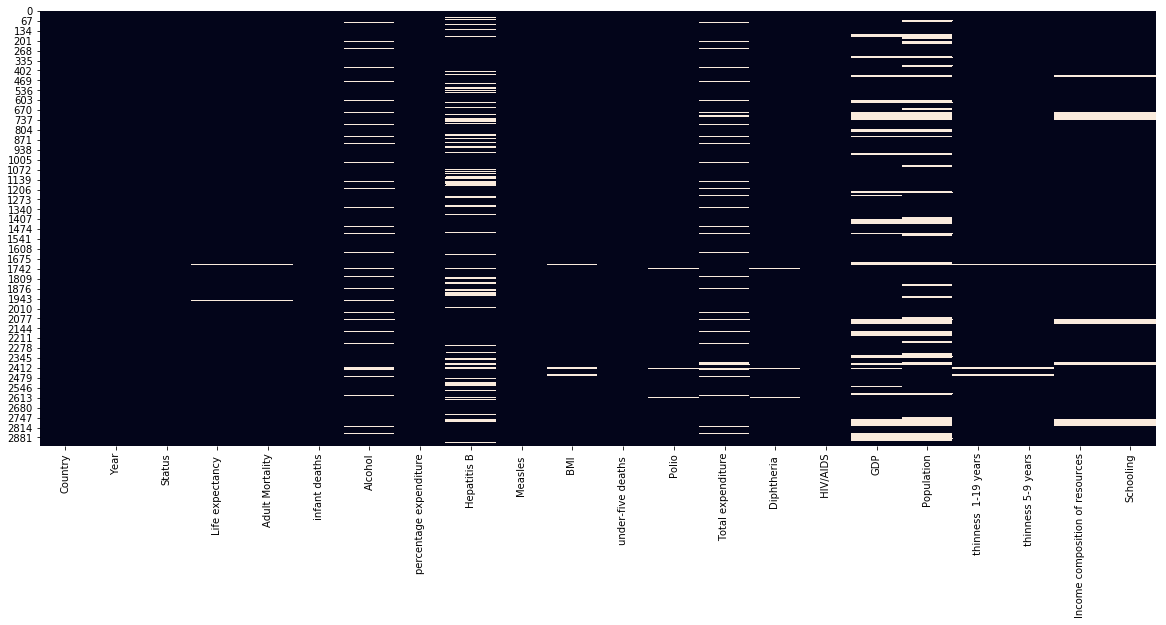

In [7]:
#visualize the missing data
fig, ax = plt.subplots(figsize=(20,8))

sns.heatmap(lifeexpectancy_df.isnull(), cbar=False)
plt.show()

### What does our missing data look like?

Let's look at what our missing data looks like so we can get a better idea of what we are working with. Below are the unique values from the top three columns with missing data. 

In [8]:
missing_data = ['Population','Hepatitis B','Total expenditure'] 

for column in missing_data:
    print("Unique values in column {} are: {}".format(column, lifeexpectancy_df[column].unique()))

Unique values in column Population are: [33736494.   327582. 31731688. ...   125525. 12366165. 12222251.]
Unique values in column Hepatitis B are: [65. 62. 64. 67. 68. 66. 63. 99. 98. 97. 96. 95.  1. 94. 91.  9.  8. 83.
 81. nan 77. 75. 72. 61. 69. 73. 85. 84. 88. 93. 89. 78. 55. 92. 86. 44.
 33. 74. 52. 49.  5. 51. 21. 45. 11. 87. 18. 56.  7.  6. 76. 82. 79. 15.
 36. 48.  4. 42. 28. 14. 47. 23. 46. 37. 39. 24. 17. 27. 25. 16.  2. 35.
 29. 26. 54. 57. 38. 59. 71. 43. 58. 41. 31. 12. 32. 22. 53. 19.]
Unique values in column Total expenditure are: [ 8.16  8.18  8.13  8.52  7.87  9.2   9.42  8.33  6.73  7.43  8.7   8.79
  8.82  7.76  7.8   8.2   6.    5.88  5.66  5.59  5.71  5.34  5.79  5.87
  6.1   5.86  6.12  6.38  6.27  6.3   6.26   nan  7.21  7.12  6.14  5.29
  4.85  5.12  5.36  4.2   3.82  3.36  3.24  3.54  3.6   3.73  3.84  3.49
  3.31  4.26  3.3   3.38  3.39  4.37  4.54  4.1   4.71  4.41  3.63  5.38
  2.79  5.54  5.33  5.39  5.65  5.63  4.86  4.69  4.27  4.34  4.21  4.53
  4.48  4.

#### Diviing deeper into popuation

Because the popuation column is missing the most data let's look at what countries are associated with this values. The reasoning behind this is that we might have to exclude countries from our examination in the future. I want to get a sense of what proportion of countries are missing to see if this is a viable option. 

In [9]:
lifeexpectancy_df[pd.isnull(lifeexpectancy_df['Population'])].Country.nunique() / \
        lifeexpectancy_df[pd.notnull(lifeexpectancy_df['Population'])].Country.nunique()

0.33793103448275863

#### Misssing population and GDP

As we can see above about 1/3 of the countries in the dataset have missing popuation data. The dataset appears to span 16 years and at first glance I thought it might have been possible to carry some of the population data from a previous year into other columns. This is, however, not possible as you can see below for one of the countries missing population data. One thing that could be done at this point is to input population data from other sources to this data set to round it out. Although there is no way to confirm if the methods to derive the two sets of data it would be better than any sort of data insertion technique.

Another interesting note is that if a country is missing GDP, generally it is missing population as well. Again one thing I would have done is sought other datasets for this information to add to the dataset. For the purposes of this exercise and in the interest of time I will probably ignore the countries that lack this information. Alternatively, I could also ignore these columns and focus on data that is consistent across the dataset. 

In [10]:
#Example of the United States data showing missing data for GDP & pop. Countries that are missing pop are usually missing
#it across the board.

lifeexpectancy_df[lifeexpectancy_df['Country']=='United States of America'].head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2794,United States of America,2015,Developed,79.3,13.0,23,NaN,0.0,92.0,188,...,93.0,NaN,95.0,0.1,NaN,NaN,0.8,0.6,NaN,NaN
2795,United States of America,2014,Developed,79.1,14.0,23,8.82,0.0,92.0,667,...,93.0,17.14,95.0,0.1,NaN,NaN,0.8,0.6,NaN,NaN
2796,United States of America,2013,Developed,78.9,16.0,23,8.82,0.0,91.0,187,...,93.0,16.90,94.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN
2797,United States of America,2012,Developed,78.8,16.0,24,8.82,0.0,9.0,55,...,93.0,17.20,94.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN
2798,United States of America,2011,Developed,78.7,16.0,25,8.67,0.0,91.0,220,...,94.0,17.60,96.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN


### Other missing values 

There are other situations where where the dataset is missing small amounts of informaton such as thinness & 1-19. Since my strategy is to exclude GDP/pop my hope is that this will take care of these columns if not I will drop.

In [11]:
lifeexpectancy_df[pd.isnull(lifeexpectancy_df[' thinness  1-19 years'])].Country.unique()

array(['Monaco', 'San Marino', 'South Sudan', 'Sudan'], dtype=object)

### Handling data missing from the most recent year

There are some situations where data is missing from 2016 across the board. Since data is available from 2015 my strategy is to interpolate from the previous year. See the example below for alcohol in the United States. This appears to also apply to Hepititis B.

In [12]:
lifeexpectancy_df[lifeexpectancy_df['Country']=='United States of America'].head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2794,United States of America,2015,Developed,79.3,13.0,23,NaN,0.0,92.0,188,...,93.0,NaN,95.0,0.1,NaN,NaN,0.8,0.6,NaN,NaN
2795,United States of America,2014,Developed,79.1,14.0,23,8.82,0.0,92.0,667,...,93.0,17.14,95.0,0.1,NaN,NaN,0.8,0.6,NaN,NaN
2796,United States of America,2013,Developed,78.9,16.0,23,8.82,0.0,91.0,187,...,93.0,16.90,94.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN
2797,United States of America,2012,Developed,78.8,16.0,24,8.82,0.0,9.0,55,...,93.0,17.20,94.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN
2798,United States of America,2011,Developed,78.7,16.0,25,8.67,0.0,91.0,220,...,94.0,17.60,96.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN


### Missing Data Strategy
Generally missing data appears to fall into 1 of three buckets. Using an 80/20 strategy I hope to eliminate most of the missing data working from the issues below in order.

#### GDP & POPULATION
I will eliminate the countries that have missing data from this set entirely. If this were a real-world dataset I would seek out complementary datasets from other sources and input the values. My reasoning is that GDP & pop are pretty unique to countires and can't be pulled from this dataset. Additionally, countries that are missing this info from this dataset are generally missing it from the whole thing. I can always call an audible later and see if I can exclude these data columns entirely and see if I can get some good values in PCA/corr

#### Alcohol & Hep B
I will interpolate the data because from my investigation it appears that 2016 are the only values missing. There may be a few missing values here and there, but because the values are so close I don't believe it will effect the dataset that much.

#### Thinness and other values
The first two steps should take care of 99% of the missing data in my estimation. Anything left I will just drop as I don't believe it will have a large effect on the data.

### Drop GDP & Population

The first move is to remove values that are NA for population. This will remove some null values that are GDP by virture of the pattern described above.

In [13]:
lifeexpectancy_droppop = lifeexpectancy_df[lifeexpectancy_df['Population'].notnull()]

In [14]:
lifeexpectancy_droppop.isnull().sum()*100/lifeexpectancy_droppop.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.087489
Adult Mortality                     0.087489
infant deaths                       0.000000
Alcohol                             6.824147
percentage expenditure              0.000000
Hepatitis B                        21.084864
Measles                             0.000000
 BMI                                1.399825
under-five deaths                   0.000000
Polio                               0.831146
Total expenditure                   6.780402
Diphtheria                          0.831146
 HIV/AIDS                           0.000000
GDP                                 0.962380
Population                          0.000000
 thinness  1-19 years               1.399825
 thinness 5-9 years                 1.399825
Income composition of resources     0.043745
Schooling                           0.000000
dtype: flo

This removed a significant amount of null values and reduced  

#### Alcohol and Hep B 

Alcohol seems to be missing from only 2016 which can be easily interpolated because the value is so close. We will do the same thing for Hep B as most countries seem to have Hep B values. This is illustrated below in Algeria's situation.

In [15]:
lifeexpectancy_droppop[lifeexpectancy_droppop['Country']=='Algeria']

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,...,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4
33,Algeria,2014,Developing,75.4,11.0,21,0.01,54.237318,95.0,0,...,95.0,7.21,95.0,0.1,547.851700,39113313.0,6.0,5.8,0.741,14.4
34,Algeria,2013,Developing,75.3,112.0,21,0.53,544.450743,95.0,25,...,95.0,7.12,95.0,0.1,5471.866766,38338562.0,5.9,5.8,0.737,14.4
35,Algeria,2012,Developing,75.1,113.0,21,0.66,555.926083,95.0,18,...,95.0,6.14,95.0,0.1,5564.825660,37565847.0,5.9,5.8,0.732,14.4
36,Algeria,2011,Developing,74.9,116.0,21,0.56,509.002041,95.0,112,...,95.0,5.29,95.0,0.1,5432.252300,36819558.0,5.9,5.8,0.724,14.0
38,Algeria,2010,Developing,74.7,119.0,21,0.45,430.717586,95.0,103,...,95.0,5.12,95.0,0.1,4463.394675,36117637.0,5.9,5.8,0.714,13.6
39,Algeria,2009,Developing,74.4,123.0,20,0.50,352.063642,94.0,107,...,94.0,5.36,95.0,0.1,3868.831230,3546576.0,6.0,5.9,0.705,13.1
40,Algeria,2008,Developing,74.1,126.0,20,0.46,43.087173,91.0,217,...,92.0,4.20,93.0,0.1,495.254866,3486715.0,6.0,5.9,0.697,12.6
41,Algeria,2007,Developing,73.8,129.0,20,0.44,320.323924,9.0,0,...,95.0,3.82,95.0,0.1,3935.183343,34376.0,6.0,5.9,0.690,12.3
42,Algeria,2006,Developing,73.4,132.0,20,0.36,270.240196,8.0,944,...,95.0,3.36,95.0,0.1,3464.617900,33777915.0,6.1,6.0,0.686,12.3


In [16]:
#make a copy
lifeexpectancy_hepandalc = lifeexpectancy_droppop.copy()

In [17]:
#interpolate alcohol
lifeexpectancy_hepandalc['Alcohol'] = lifeexpectancy_hepandalc['Alcohol'].interpolate()

#interpolate Hep B
lifeexpectancy_hepandalc['Hepatitis B'] = lifeexpectancy_hepandalc['Hepatitis B'].interpolate()

In [18]:
#interpolate total expenditure
lifeexpectancy_hepandalc['Total expenditure'] = lifeexpectancy_hepandalc['Total expenditure'].interpolate()

In [19]:
#recheck out values
lifeexpectancy_hepandalc.isnull().sum()*100/lifeexpectancy_hepandalc.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.087489
Adult Mortality                    0.087489
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Hepatitis B                        0.000000
Measles                            0.000000
 BMI                               1.399825
under-five deaths                  0.000000
Polio                              0.831146
Total expenditure                  0.000000
Diphtheria                         0.831146
 HIV/AIDS                          0.000000
GDP                                0.962380
Population                         0.000000
 thinness  1-19 years              1.399825
 thinness 5-9 years                1.399825
Income composition of resources    0.043745
Schooling                          0.000000
dtype: float64

### Drop the rest of the values

The rest of the missing data appears to make up a small percentage so we will drop the remaining. As you can see below we now have 2230 non-null values in 22 columns.

In [20]:
lifeexpectancy_data = lifeexpectancy_hepandalc.dropna()

In [21]:
#recheck again
lifeexpectancy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2230 non-null object
Year                               2230 non-null int64
Status                             2230 non-null object
Life expectancy                    2230 non-null float64
Adult Mortality                    2230 non-null float64
infant deaths                      2230 non-null int64
Alcohol                            2230 non-null float64
percentage expenditure             2230 non-null float64
Hepatitis B                        2230 non-null float64
Measles                            2230 non-null int64
 BMI                               2230 non-null float64
under-five deaths                  2230 non-null int64
Polio                              2230 non-null float64
Total expenditure                  2230 non-null float64
Diphtheria                         2230 non-null float64
 HIV/AIDS                          2230 non-null

### Categorical Data

Now let's look at categorical data. There are three categorical columns: Country, Status, and year.

As you can see below there are 141 unique countries, two states of status - developing & developed, and 16 years of of data. For convenience I will go ahead and make another column with status data 

In [22]:
lifeexpectancy_data['Country'].nunique()

141

In [23]:
lifeexpectancy_data['Status'].unique()

array(['Developing', 'Developed'], dtype=object)

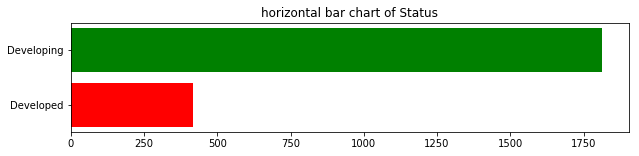

In [24]:
# bar chart of Status
plt.figure(figsize=(10,2))
plt.barh(lifeexpectancy_data.groupby("Status")["Status"].count().index, 
        lifeexpectancy_data.groupby("Status")["Status"].count(), 
        color=["red","green"])
plt.title("horizontal bar chart of Status")

plt.show()

***As you can see above the horizontal barchart shows that there are far more developing countries in the dataset than developed.

In [25]:
lifeexpectancy_data['Year'].unique()

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000])

In [26]:
encoder = OrdinalEncoder()

lifeexpectancy_data['Status_encoded'] = encoder.fit_transform(lifeexpectancy_data.Status.values.reshape(-1, 1))

#### 1 == Developing country
#### 0 == Developed country

In [27]:
lifeexpectancy_data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_encoded
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1.0
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1.0
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,1.0
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,1.0


### Numerical Features

Now that we have dealt with the missing data let's look at the numerical features to gain a deeper understanding of our dataset. 

In [28]:
columns = [column_name for column_name in lifeexpectancy_data.columns]

In [29]:
numerical_data = [
 'Life expectancy ',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles ',
 ' BMI ',
 'under-five deaths ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 ' HIV/AIDS',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [30]:
lifeexpectancy_data[numerical_data].describe()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2.230000e+03,2230.000000,2230.000000,2230.000000,2230.000000
mean,68.839462,168.466368,34.189238,4.699935,850.569863,76.885426,2585.247982,37.423094,47.453363,81.497309,6.015657,81.599552,2.077265,6710.794018,1.285438e+07,4.875067,4.936861,0.624812,12.014574
std,9.830078,129.017982,133.294148,3.999981,2188.214128,25.312557,11685.334261,19.857087,181.180765,23.723012,2.332972,23.796556,5.709270,13622.316455,6.174074e+07,4.680947,4.779264,0.206416,3.270858
min,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,1.400000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,62.500000,71.000000,0.000000,1.010000,22.120565,67.000000,0.000000,18.725000,1.000000,76.000000,4.410000,77.000000,0.100000,436.516301,1.938082e+05,1.500000,1.500000,0.486000,10.000000
50%,71.500000,145.500000,3.000000,4.090000,99.722393,87.000000,17.000000,42.000000,4.000000,92.000000,5.900000,92.000000,0.100000,1537.810425,1.370540e+06,2.900000,3.100000,0.669000,12.200000
75%,75.500000,232.000000,22.000000,7.482500,508.728404,95.000000,425.750000,55.800000,29.000000,97.000000,7.595000,96.000000,1.100000,5236.633341,7.373548e+06,7.300000,7.400000,0.771000,14.400000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


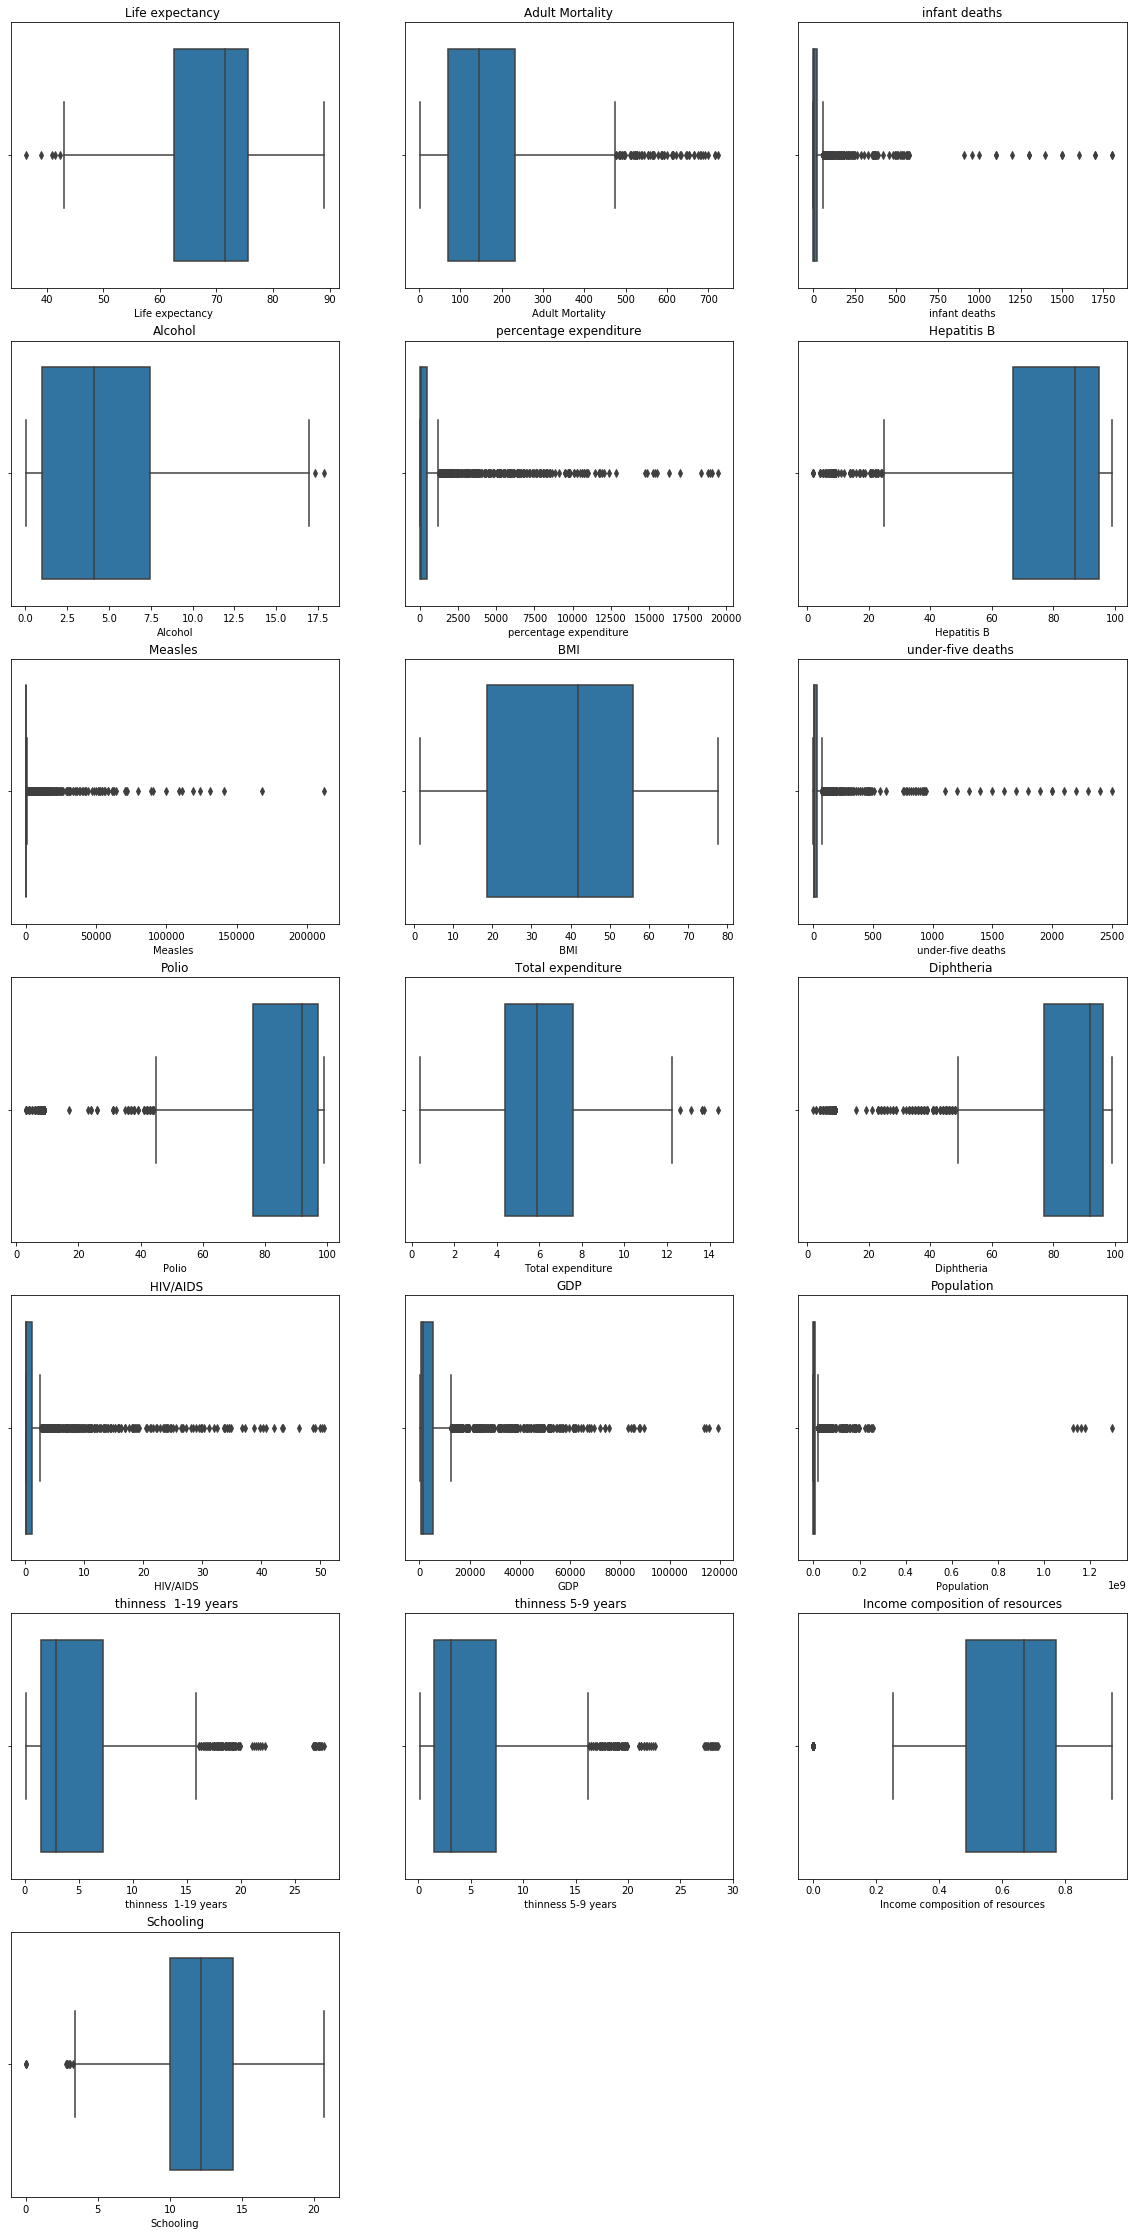

In [31]:
plt.figure(figsize = (20,40))

for i in range(19):
    plt.subplot(7,3,i+1)
    sns.boxplot(lifeexpectancy_data[numerical_data[i]].dropna())
    plt.title(numerical_data[i])

plt.show()

In [32]:
#IQR range
Q1 = lifeexpectancy_data.quantile(0.25)
Q3 = lifeexpectancy_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                               7.000000e+00
Life expectancy                    1.300000e+01
Adult Mortality                    1.610000e+02
infant deaths                      2.200000e+01
Alcohol                            6.472500e+00
percentage expenditure             4.866078e+02
Hepatitis B                        2.800000e+01
Measles                            4.257500e+02
 BMI                               3.707500e+01
under-five deaths                  2.800000e+01
Polio                              2.100000e+01
Total expenditure                  3.185000e+00
Diphtheria                         1.900000e+01
 HIV/AIDS                          1.000000e+00
GDP                                4.800117e+03
Population                         7.179740e+06
 thinness  1-19 years              5.800000e+00
 thinness 5-9 years                5.900000e+00
Income composition of resources    2.850000e-01
Schooling                          4.400000e+00
Status_encoded                     0.000

In [33]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.

for column in numerical_data:
    q75, q25 = np.percentile(lifeexpectancy_data[column], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(column, \
                len((np.where((lifeexpectancy_data[column] > max_val) | \
                    (lifeexpectancy_data[column] < min_val))[0])),len((np.where((lifeexpectancy_data[column] > max_val) | \
                        (lifeexpectancy_data[column] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in Life expectancy  : 5 and 0.25163563160543534
Number of outliers and percentage of it in Adult Mortality : 70 and 3.5228988424760947
Number of outliers and percentage of it in infant deaths : 245 and 12.330145948666331
Number of outliers and percentage of it in Alcohol : 2 and 0.10065425264217413
Number of outliers and percentage of it in percentage expenditure : 290 and 14.594866633115249
Number of outliers and percentage of it in Hepatitis B : 161 and 8.102667337695017
Number of outliers and percentage of it in Measles  : 406 and 20.43281328636135
Number of outliers and percentage of it in  BMI  : 0 and 0.0
Number of outliers and percentage of it in under-five deaths  : 307 and 15.45042778057373
Number of outliers and percentage of it in Polio : 187 and 9.411172622043281
Number of outliers and percentage of it in Total expenditure : 6 and 0.3019627579265224
Number of outliers and percentage of it in Diphtheria  : 227 and 11.424257674886764
Nu

### Outliers

Log transform the data

In [34]:
lifeexpectancy_logtf = lifeexpectancy_data.copy()

In [35]:
for column in numerical_data:
    lifeexpectancy_logtf[column] = np.log(lifeexpectancy_data[column])

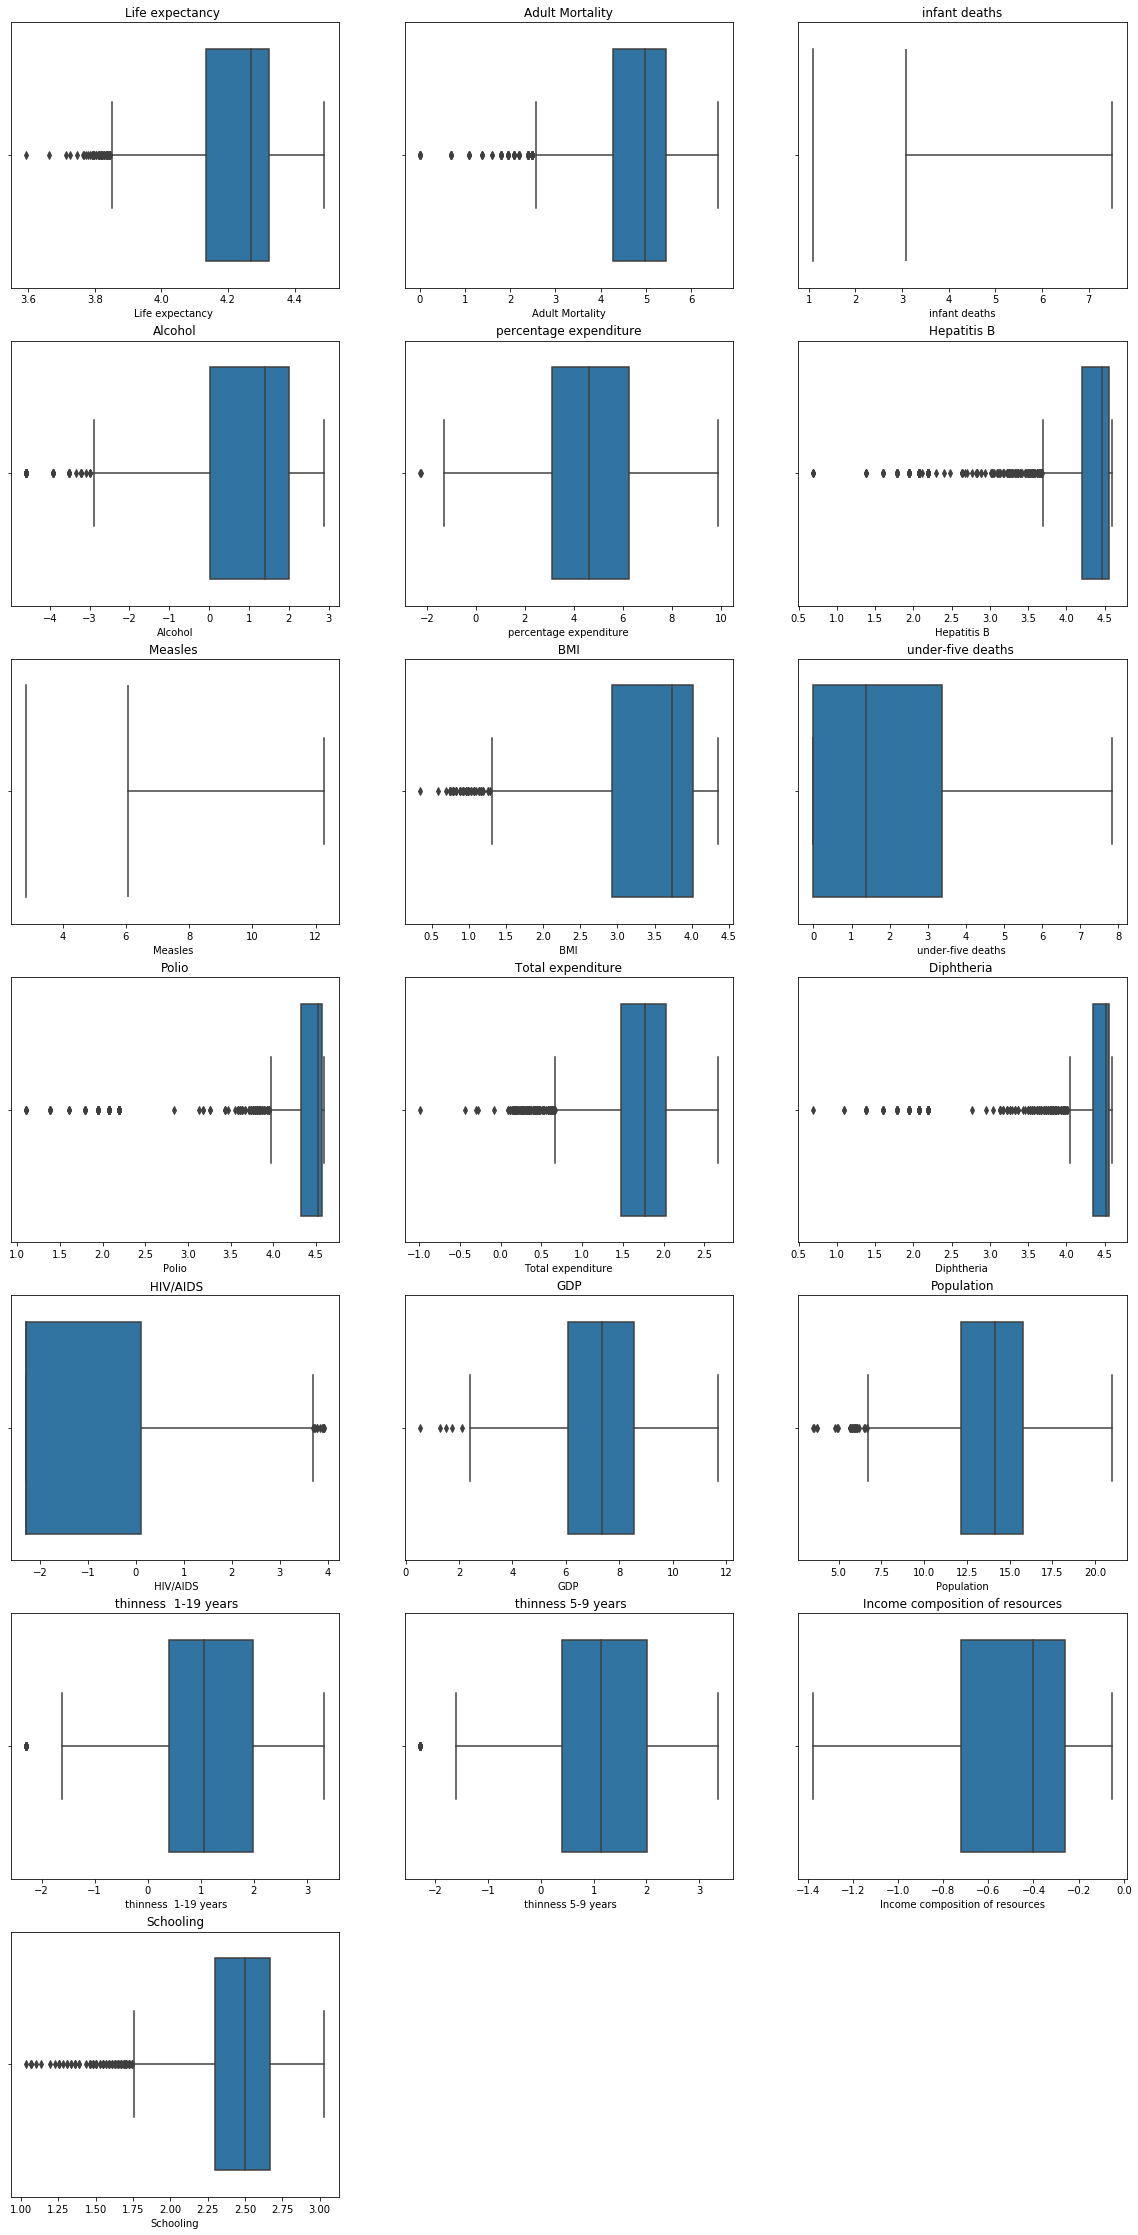

In [36]:
plt.figure(figsize = (20,40))

for i in range(19):
    plt.subplot(7,3,i+1)
    sns.boxplot(lifeexpectancy_logtf[numerical_data[i]])
    plt.title(numerical_data[i])

plt.show()

#### Winsorize data

In [37]:
lifeexpectancy_winsorize = lifeexpectancy_data.copy()

In [38]:
for column in numerical_data:
    lifeexpectancy_winsorize[numerical_data] = winsorize(lifeexpectancy_winsorize[numerical_data])

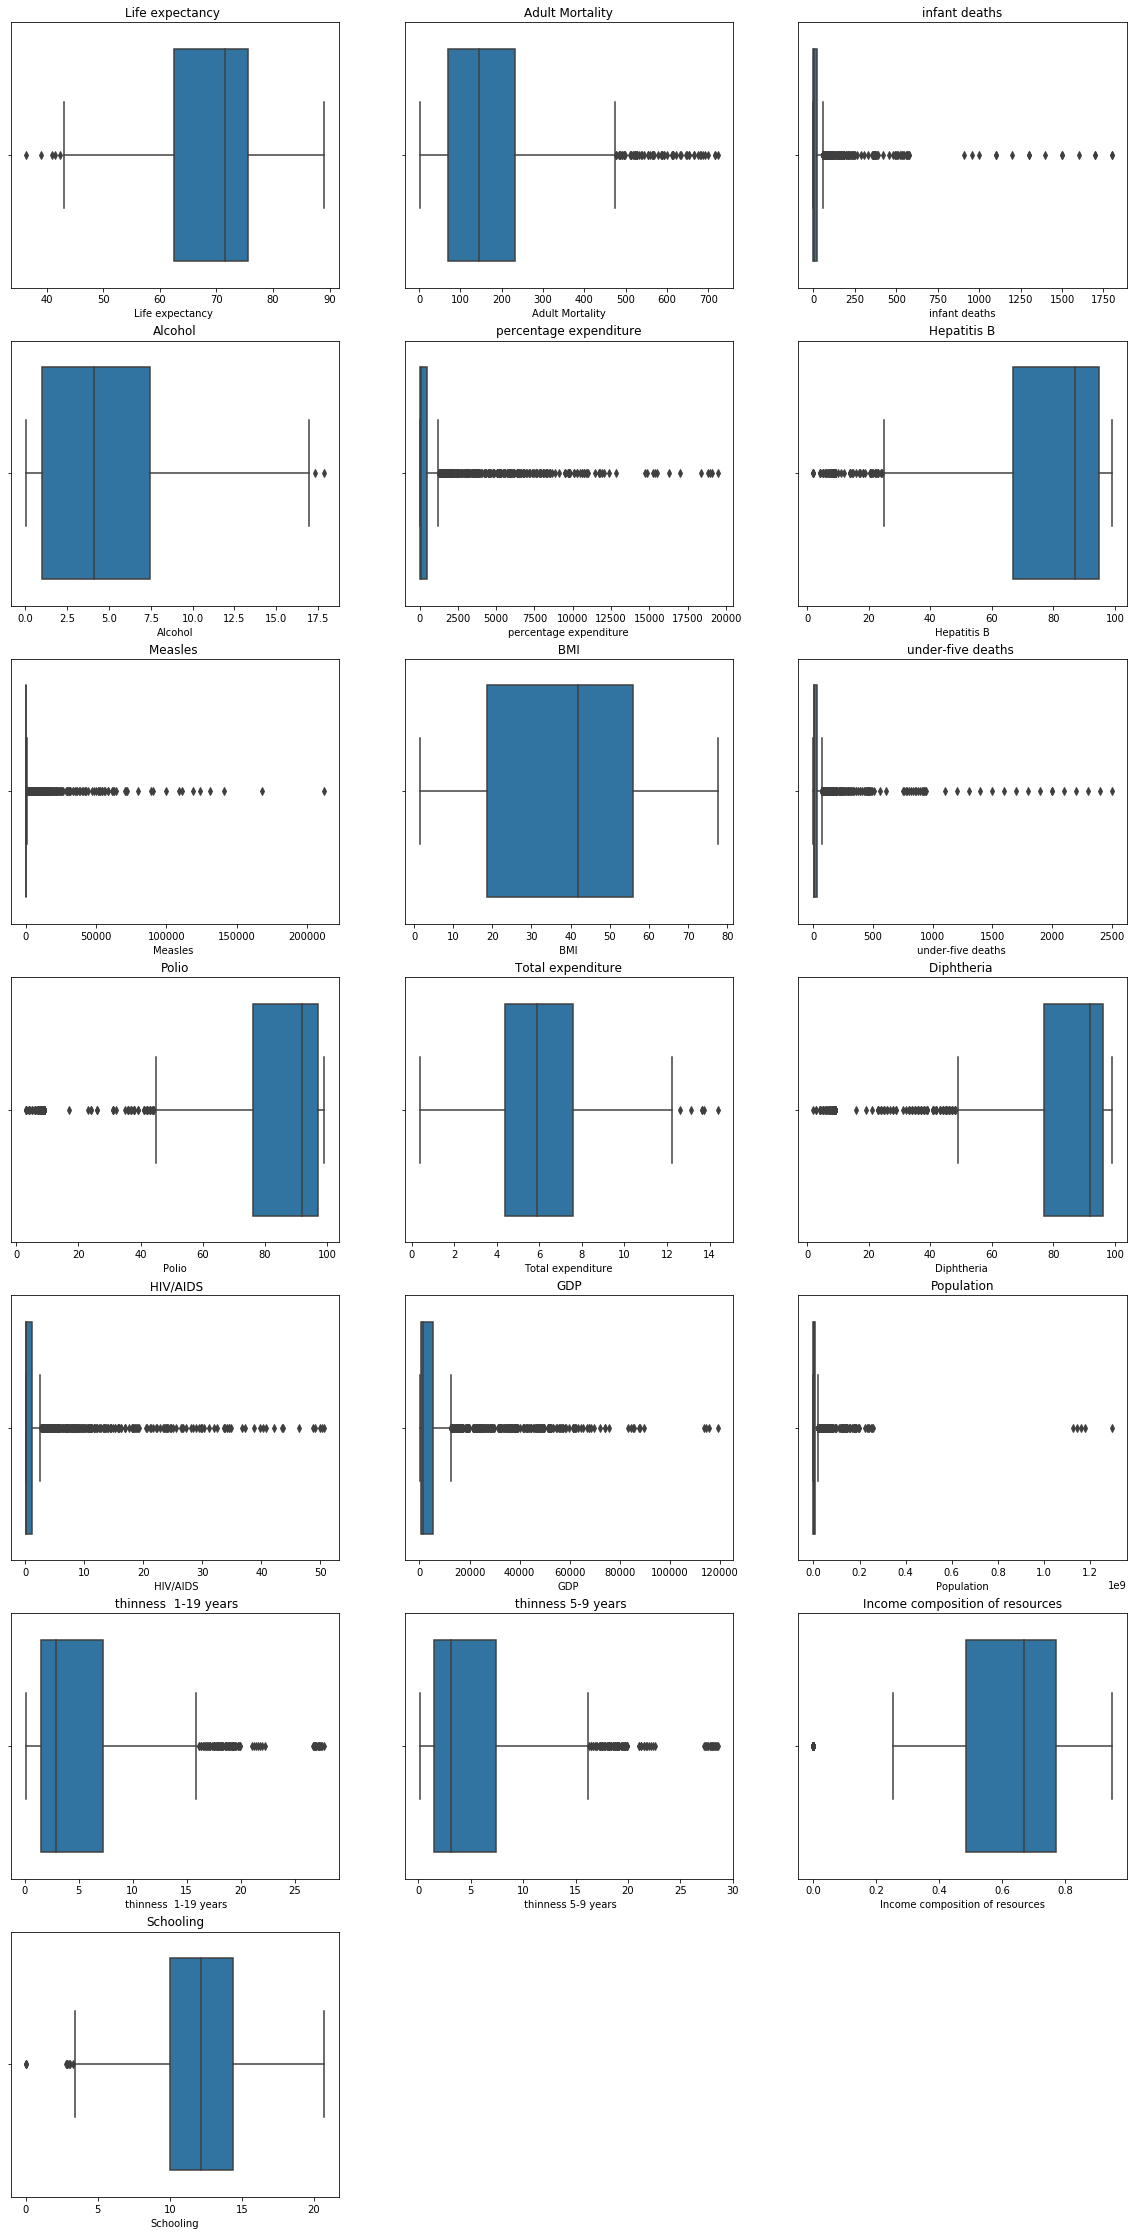

In [39]:
plt.figure(figsize = (20,40))

for i in range(19):
    plt.subplot(7,3,i+1)
    sns.boxplot(lifeexpectancy_winsorize[numerical_data[i]])
    plt.title(numerical_data[i])

plt.show()

In [40]:
lifeexpectancy_winsorize['Life expectancy '] = winsorize(lifeexpectancy_data['Life expectancy '],(0.01,0))
lifeexpectancy_winsorize['Adult Mortality'] = winsorize(lifeexpectancy_data['Adult Mortality'],(0,0.04))
lifeexpectancy_winsorize['infant deaths'] = winsorize(lifeexpectancy_data['infant deaths'],(0,0.15))
lifeexpectancy_winsorize['Alcohol'] = winsorize(lifeexpectancy_data['Alcohol'],(0,0.01))
lifeexpectancy_winsorize['percentage expenditure'] = winsorize(lifeexpectancy_data['percentage expenditure'],(0,0.15))
lifeexpectancy_winsorize['Hepatitis B'] = winsorize(lifeexpectancy_data['Hepatitis B'],(0.11,0))
lifeexpectancy_winsorize['Measles '] = winsorize(lifeexpectancy_data['Measles '],(0,0.19))
lifeexpectancy_winsorize[' BMI '] = winsorize(lifeexpectancy_data[' BMI '],(0.01,0))
lifeexpectancy_winsorize['under-five deaths '] = winsorize(lifeexpectancy_data['under-five deaths '],(0,0.15))
lifeexpectancy_winsorize['Polio'] = winsorize(lifeexpectancy_data['Polio'],(0.19,0))
lifeexpectancy_winsorize['Total expenditure'] = winsorize(lifeexpectancy_data['Total expenditure'],(0,0.01))
lifeexpectancy_winsorize['Diphtheria '] = winsorize(lifeexpectancy_data['Diphtheria '],(0.12,0))
lifeexpectancy_winsorize[' HIV/AIDS'] = winsorize(lifeexpectancy_data[' HIV/AIDS'],(0,0.18))
lifeexpectancy_winsorize['GDP'] = winsorize(lifeexpectancy_data['GDP'],(0,0.17))
lifeexpectancy_winsorize['Population'] = winsorize(lifeexpectancy_data['Population'],(0,0.13))
lifeexpectancy_winsorize[' thinness 5-9 years'] = winsorize(lifeexpectancy_data[' thinness 5-9 years'],(0,0.04))
lifeexpectancy_winsorize[' thinness  1-19 years'] = winsorize(lifeexpectancy_data[' thinness  1-19 years'],(0,0.04))
lifeexpectancy_winsorize['Income composition of resources'] = winsorize(lifeexpectancy_data['Income composition of resources'],(0.05,0))
lifeexpectancy_winsorize['Schooling'] = winsorize(lifeexpectancy_data['Schooling'],(0.02,0.01))


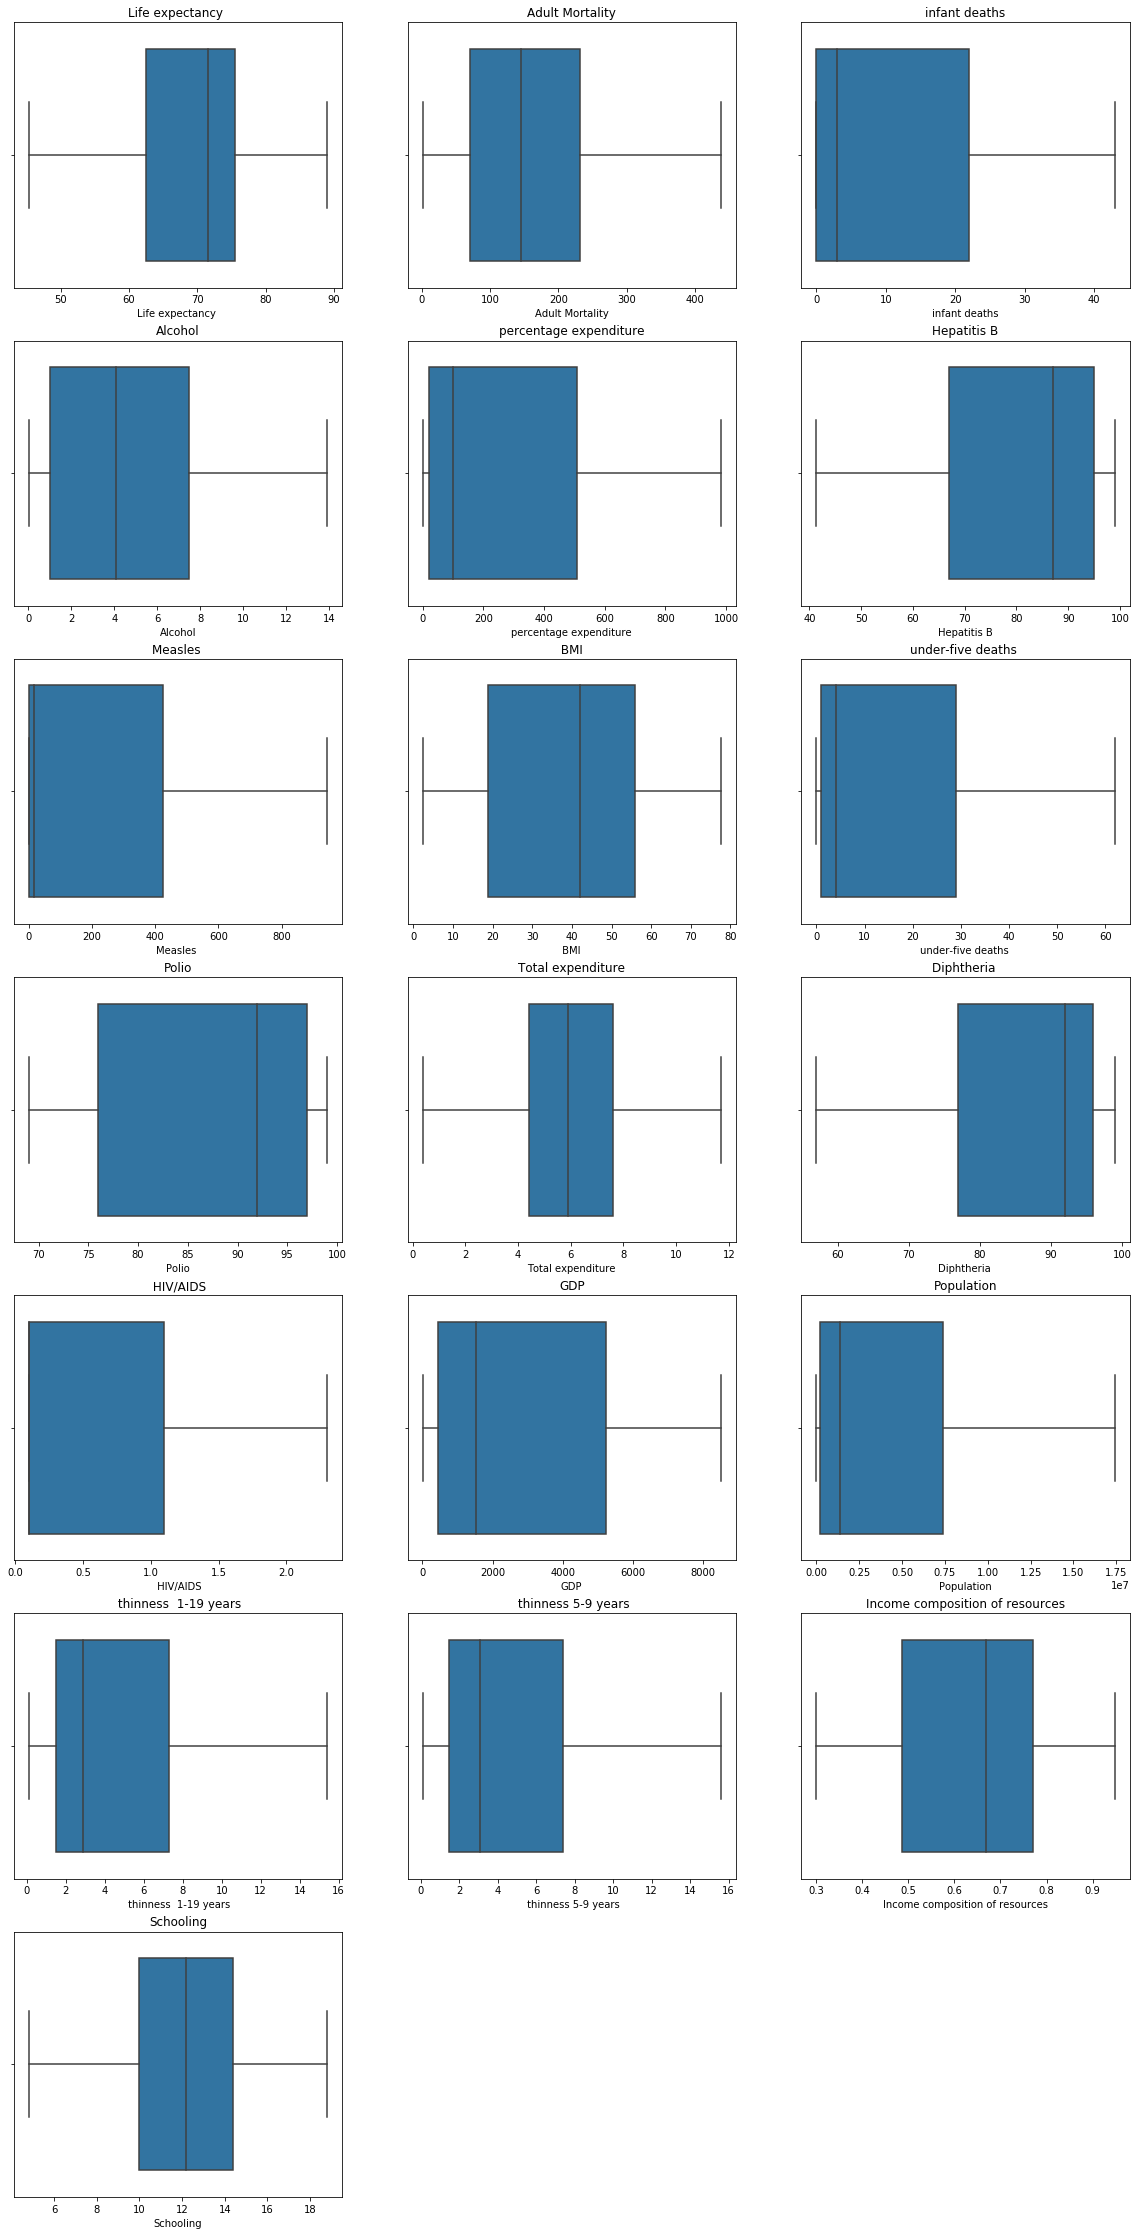

In [41]:
plt.figure(figsize = (20,40))

for i in range(19):
    plt.subplot(7,3,i+1)
    sns.boxplot(lifeexpectancy_winsorize[numerical_data[i]])
    plt.title(numerical_data[i])

plt.show()

In [42]:
for column in numerical_data:
    q75, q25 = np.percentile(lifeexpectancy_winsorize[column], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(column, \
                len((np.where((lifeexpectancy_winsorize[column] > max_val) | \
                    (lifeexpectancy_winsorize[column] < min_val))[0])),\
                        len((np.where((lifeexpectancy_winsorize[column] > max_val) | \
                            (lifeexpectancy_winsorize[column] < min_val))[0]))*100/2230))

Number of outliers and percentage of it in Life expectancy  : 0 and 0.0
Number of outliers and percentage of it in Adult Mortality : 0 and 0.0
Number of outliers and percentage of it in infant deaths : 0 and 0.0
Number of outliers and percentage of it in Alcohol : 0 and 0.0
Number of outliers and percentage of it in percentage expenditure : 0 and 0.0
Number of outliers and percentage of it in Hepatitis B : 0 and 0.0
Number of outliers and percentage of it in Measles  : 0 and 0.0
Number of outliers and percentage of it in  BMI  : 0 and 0.0
Number of outliers and percentage of it in under-five deaths  : 0 and 0.0
Number of outliers and percentage of it in Polio : 0 and 0.0
Number of outliers and percentage of it in Total expenditure : 0 and 0.0
Number of outliers and percentage of it in Diphtheria  : 0 and 0.0
Number of outliers and percentage of it in  HIV/AIDS : 0 and 0.0
Number of outliers and percentage of it in GDP : 0 and 0.0
Number of outliers and percentage of it in Population : 

### Data Exploration

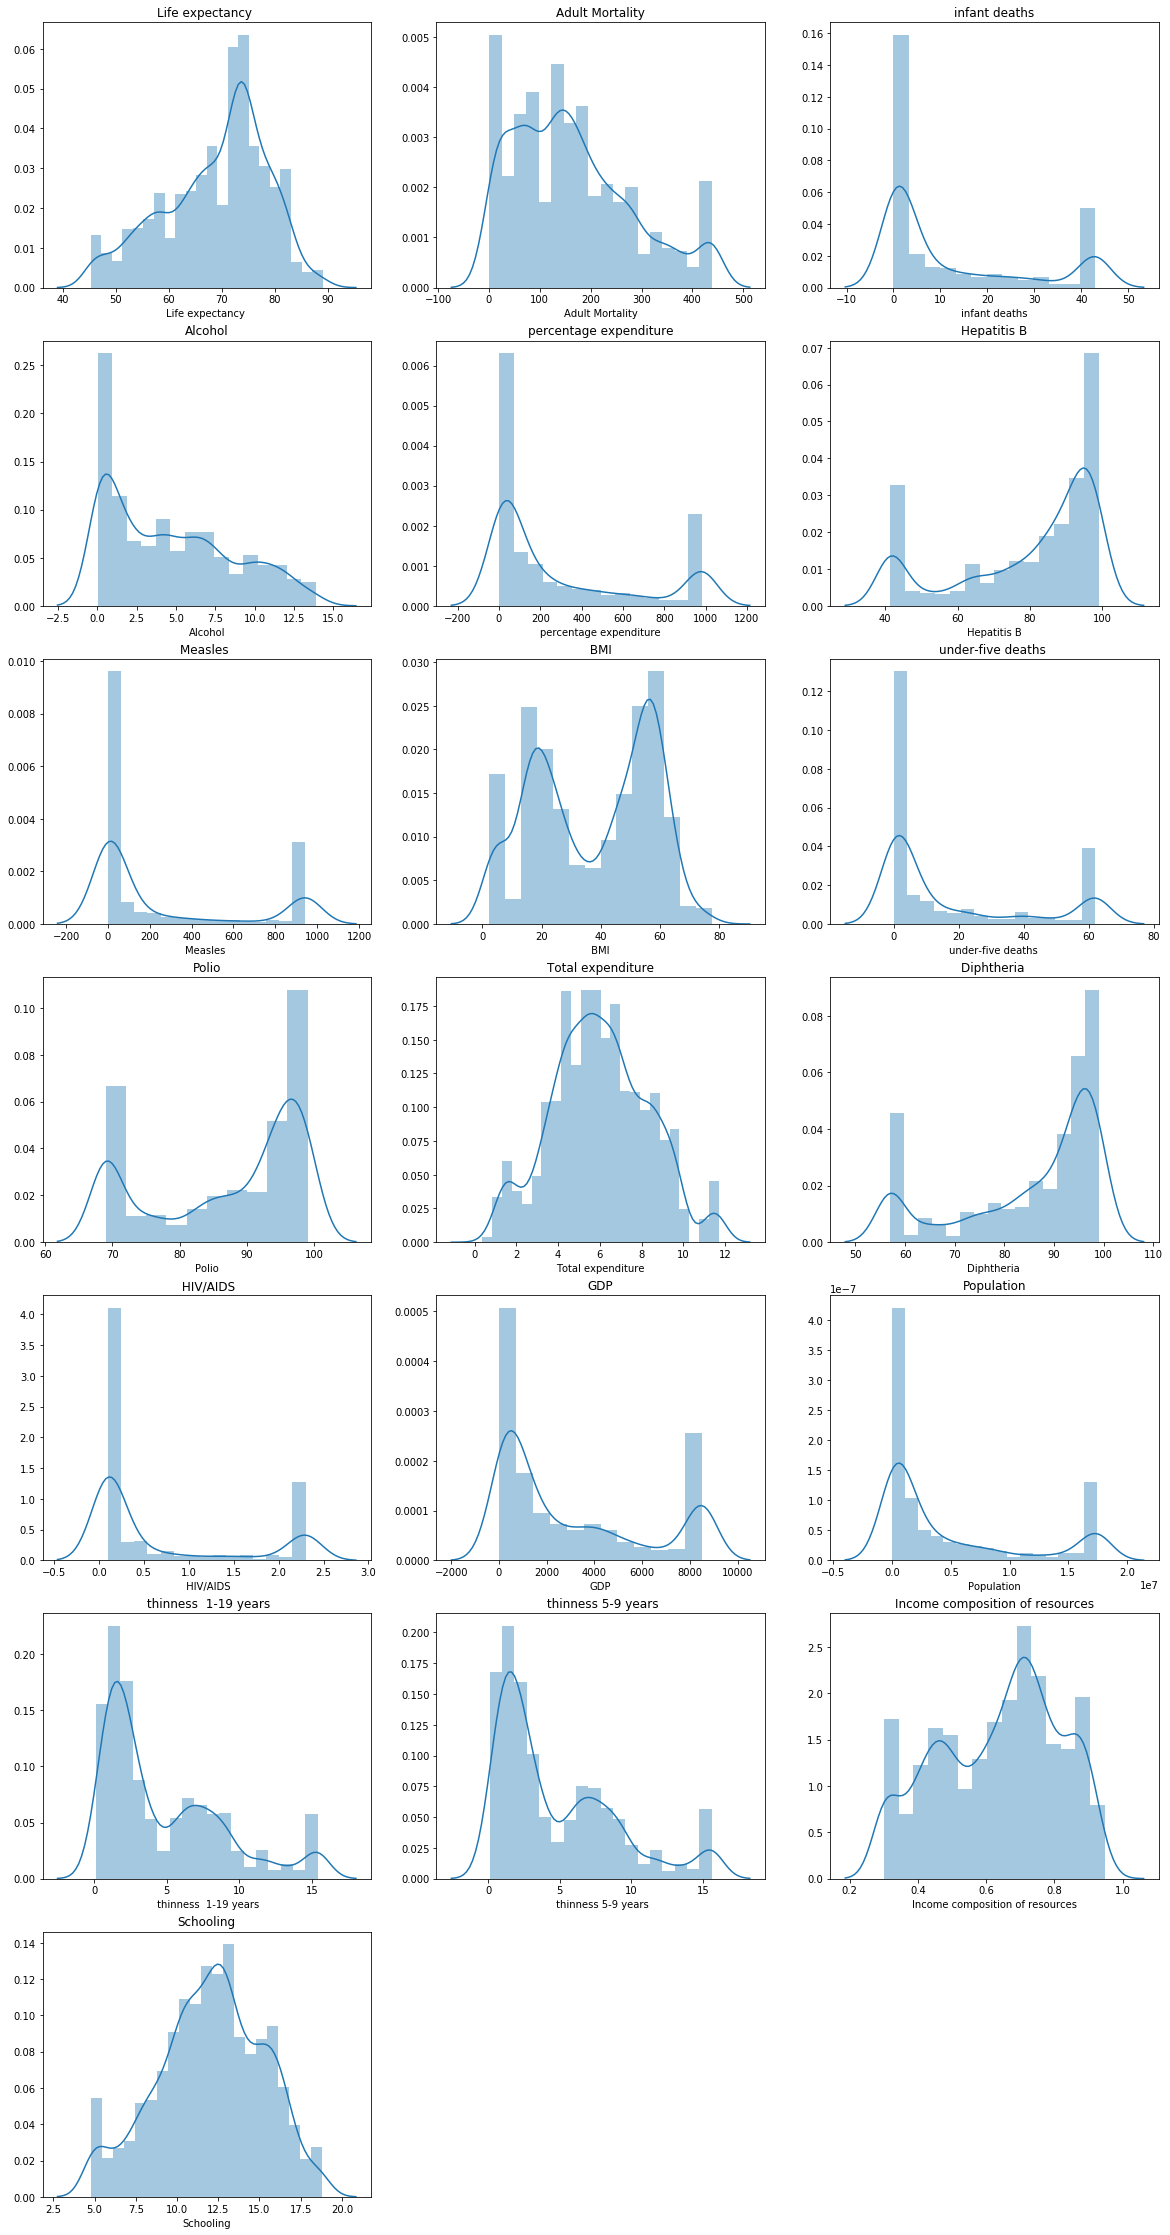

In [43]:
plt.figure(figsize = (20,40))

for i in range(19):
    plt.subplot(7,3,i+1)
    sns.distplot(lifeexpectancy_winsorize[numerical_data[i]])
    plt.title(numerical_data[i])

plt.show()

#### Jarque-bera

In [44]:
for column in numerical_data:
    jb_stats = jarque_bera(np.sqrt(lifeexpectancy_winsorize[column]))
    #norm_stats = normaltest(np.sqrt(lifeexpectancy_boxcox[column]))
    
    print(str(column) + (' ') + str(jb_stats))

Life expectancy  (174.7869255548924, 0.0)
Adult Mortality (46.741468600819545, 7.083034159194312e-11)
infant deaths (234.83263730606598, 0.0)
Alcohol (129.24215182240127, 0.0)
percentage expenditure (221.2259964035757, 0.0)
Hepatitis B (422.98609617102494, 0.0)
Measles  (339.46245129085867, 0.0)
 BMI  (177.87406597608094, 0.0)
under-five deaths  (253.8520904284146, 0.0)
Polio (282.09998232628135, 0.0)
Total expenditure (93.08905628686219, 0.0)
Diphtheria  (428.62739677710266, 0.0)
 HIV/AIDS (403.4026016417203, 0.0)
GDP (200.665845379082, 0.0)
Population (254.82004305213346, 0.0)
 thinness  1-19 years (135.94256358466194, 0.0)
 thinness 5-9 years (123.830027319835, 0.0)
Income composition of resources (146.71421669110467, 0.0)
Schooling (123.08180682498744, 0.0)


In [45]:
lifeexpectancy_winsorize[numerical_data].describe()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2.230000e+03,2230.000000,2230.000000,2230.000000,2230.000000
mean,68.858341,164.164574,12.377130,4.687276,298.078787,79.449819,251.586547,37.424978,17.326457,86.997309,6.009045,85.424664,0.675381,3033.501982,4.751101e+06,4.700717,4.746233,0.636642,12.027399
std,9.780510,116.574848,16.005689,3.967164,359.124626,19.356181,375.218524,19.853736,23.127617,11.167070,2.314551,14.110772,0.872345,3112.350132,6.225661e+06,4.108749,4.150550,0.176919,3.190932
min,45.300000,1.000000,0.000000,0.010000,0.000000,41.357143,0.000000,2.300000,0.000000,69.000000,0.370000,57.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.301000,4.800000
25%,62.500000,71.000000,0.000000,1.010000,22.120565,67.000000,0.000000,18.725000,1.000000,76.000000,4.410000,77.000000,0.100000,436.516301,1.938082e+05,1.500000,1.500000,0.486000,10.000000
50%,71.500000,145.500000,3.000000,4.090000,99.722393,87.000000,17.000000,42.000000,4.000000,92.000000,5.900000,92.000000,0.100000,1537.810425,1.370540e+06,2.900000,3.100000,0.669000,12.200000
75%,75.500000,232.000000,22.000000,7.482500,508.728404,95.000000,425.750000,55.800000,29.000000,97.000000,7.595000,96.000000,1.100000,5236.633341,7.373548e+06,7.300000,7.400000,0.771000,14.400000
max,89.000000,438.000000,43.000000,13.890000,983.251809,99.000000,944.000000,77.600000,62.000000,99.000000,11.700000,99.000000,2.300000,8513.564645,1.741527e+07,15.400000,15.600000,0.948000,18.800000


In [46]:
status = lifeexpectancy_winsorize.groupby('Status')['Life expectancy '].mean()
status = pd.DataFrame(status)

#sns.barplot(x='Status',y='Life expectancy ',data=status)

status

,Life expectancy
Status,
Developed,79.27476
Developing,66.46957


#### Normalize the Data

In [47]:
lifeexpectancy_normal = lifeexpectancy_winsorize.copy()

In [48]:
for column in numerical_data:
    lifeexpectancy_normal[column] = \
            normalize(np.array(lifeexpectancy_normal[column]).reshape(1,-1)).reshape(-1,1)

In [51]:
lifeexpectancy_normal.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_encoded
0,Afghanistan,2015,Developing,0.019791,0.027663,0.045011,0.000034,0.003235,0.016833,0.044257,...,0.026835,0.015898,0.00192,0.002847,0.047097,0.052239,0.052399,0.015351,0.017188,1.0
1,Afghanistan,2014,Developing,0.018238,0.028504,0.045011,0.000034,0.003336,0.016056,0.023066,...,0.026901,0.015164,0.00192,0.002986,0.000886,0.052239,0.052399,0.015255,0.017018,1.0
2,Afghanistan,2013,Developing,0.018238,0.028189,0.045011,0.000034,0.003323,0.016574,0.020159,...,0.026737,0.015653,0.00192,0.003078,0.047097,0.052239,0.052399,0.015063,0.016848,1.0
3,Afghanistan,2012,Developing,0.018116,0.028609,0.045011,0.000034,0.003548,0.017351,0.044257,...,0.028019,0.016387,0.00192,0.003265,0.009998,0.052239,0.052399,0.014838,0.016678,1.0
4,Afghanistan,2011,Developing,0.018025,0.028925,0.045011,0.000034,0.000322,0.017610,0.044257,...,0.025882,0.016631,0.00192,0.000310,0.008055,0.052239,0.052399,0.014550,0.016167,1.0


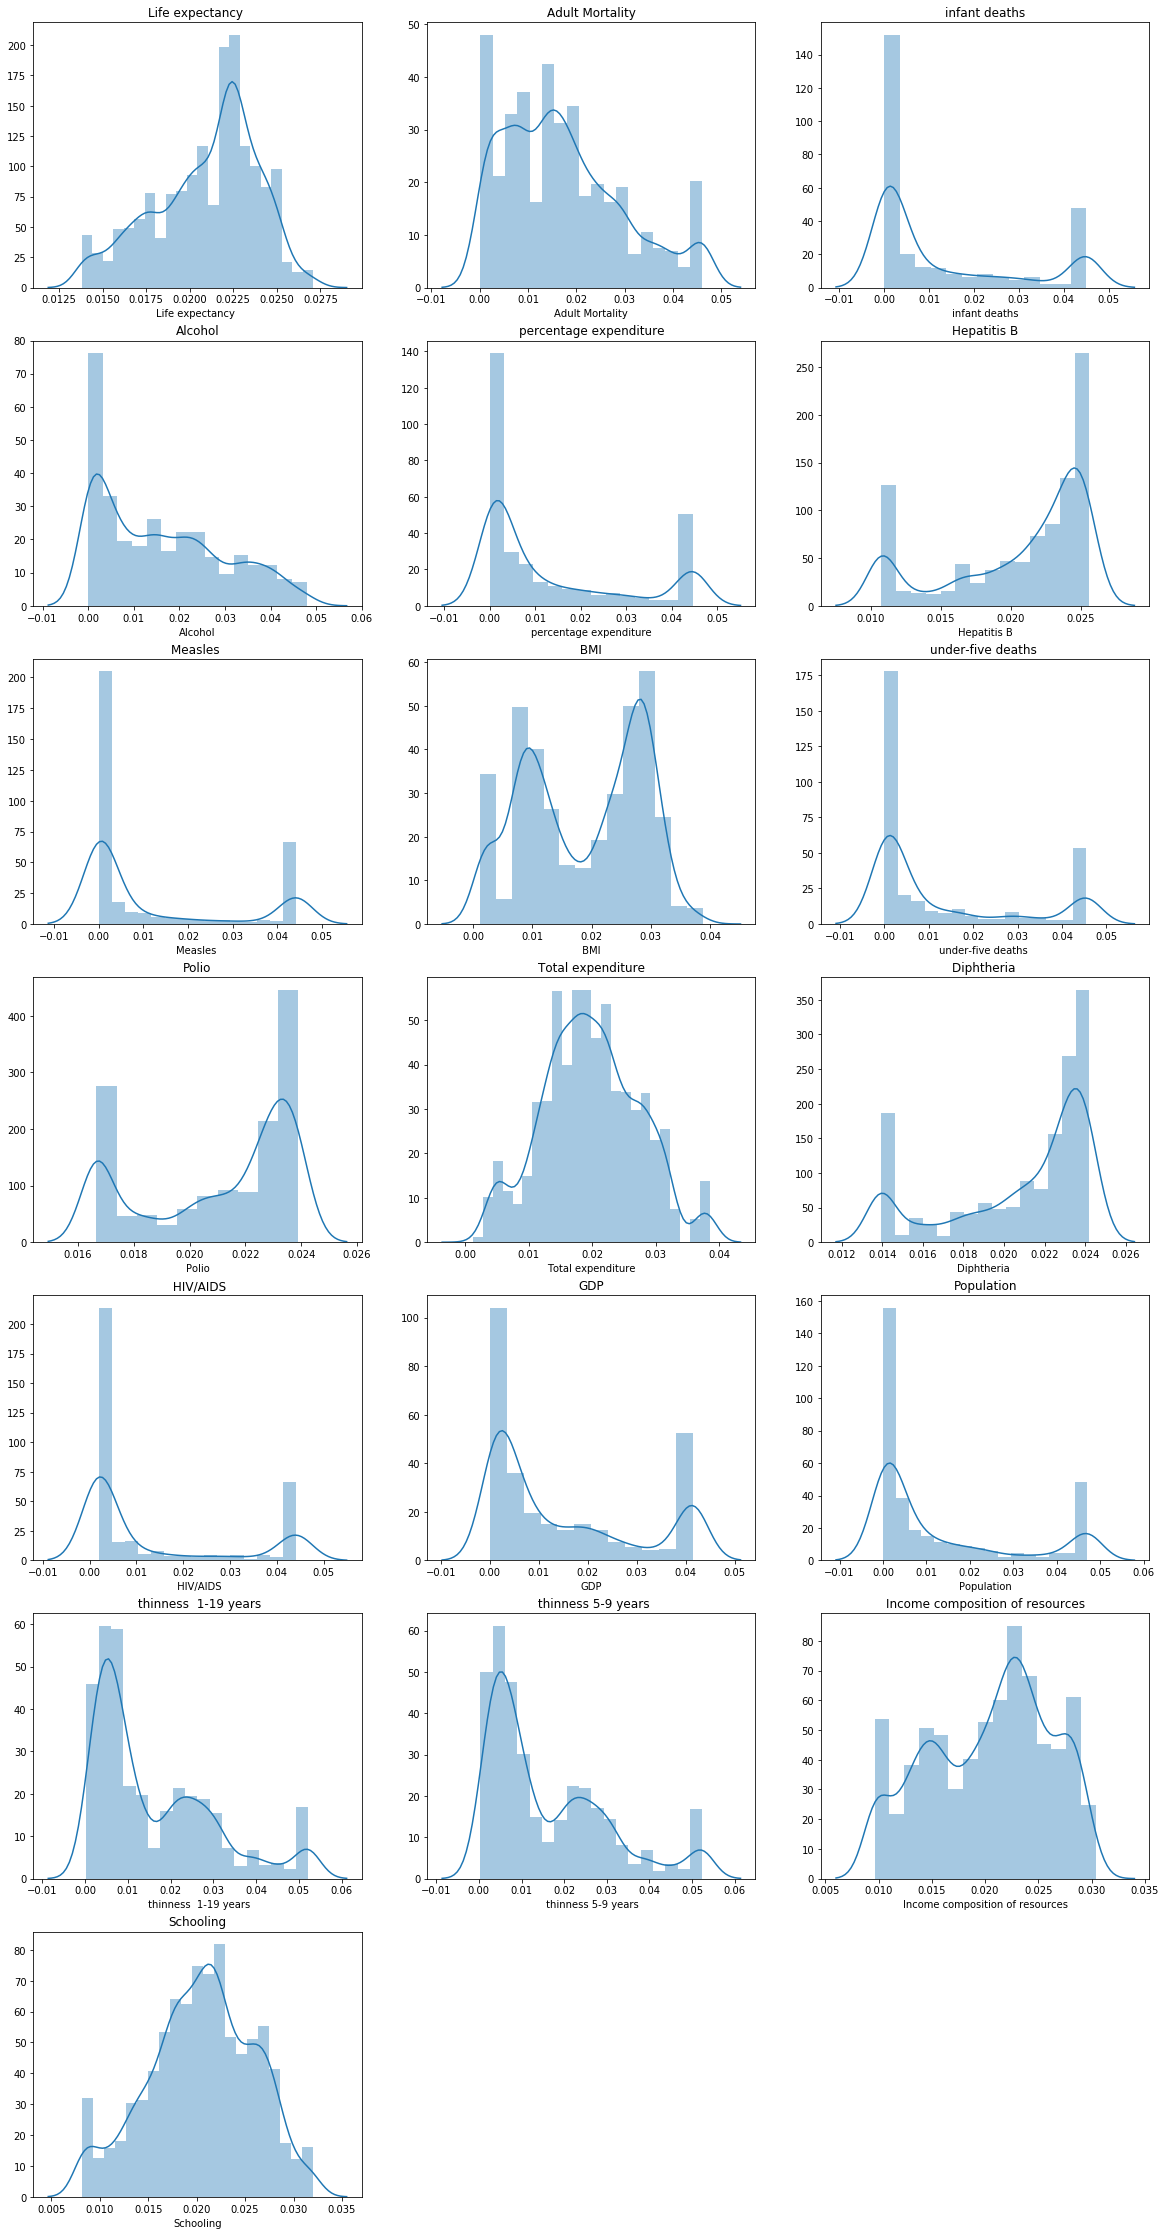

In [49]:
plt.figure(figsize = (20,40))

for i in range(19):
    plt.subplot(7,3,i+1)
    sns.distplot(lifeexpectancy_normal[numerical_data[i]])
    plt.title(numerical_data[i])

plt.show()

In [50]:
for column in numerical_data:
    jb_stats = jarque_bera(np.sqrt(lifeexpectancy_normal[column]))
    
    print(str(column) + (' ') + str(jb_stats))

Life expectancy  (174.78692555489562, 0.0)
Adult Mortality (46.74146860081945, 7.083034159194312e-11)
infant deaths (234.83263730606615, 0.0)
Alcohol (129.2421518224012, 0.0)
percentage expenditure (221.2259964035759, 0.0)
Hepatitis B (422.98609617102545, 0.0)
Measles  (339.462451290859, 0.0)
 BMI  (177.87406597608094, 0.0)
under-five deaths  (253.85209042841487, 0.0)
Polio (282.0999823262821, 0.0)
Total expenditure (93.08905628686226, 0.0)
Diphtheria  (428.62739677710215, 0.0)
 HIV/AIDS (403.4026016417199, 0.0)
GDP (200.665845379082, 0.0)
Population (254.8200430521335, 0.0)
 thinness  1-19 years (135.94256358466208, 0.0)
 thinness 5-9 years (123.8300273198353, 0.0)
Income composition of resources (146.71421669110444, 0.0)
Schooling (123.08180682498674, 0.0)


### PCA

In [69]:
X = lifeexpectancy_normal[numerical_data]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=4)
lifeexpectancy_normal['pca_1'] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.44909764 0.09384603 0.08850878 0.0646021 ]


In [75]:
pc = sklearn_pca.fit_transform(X)

pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2','PC3','PC4'])
#pc_df['Cluster'] = Y1
pc_df.head()

,PC1,PC2,PC3,PC4
0,4.760334,2.002072,1.987838,-0.284628
1,4.641353,0.505439,0.532600,0.123946
2,4.761526,1.511988,1.528432,-0.075214
3,4.806052,0.963426,1.229686,0.196590
4,4.965795,0.730265,1.274826,0.033050


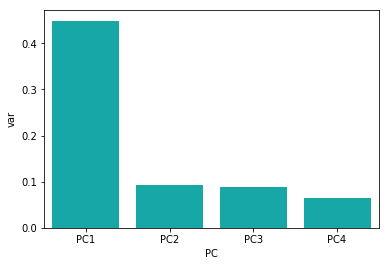

In [77]:
df = pd.DataFrame({'var':sklearn_pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");

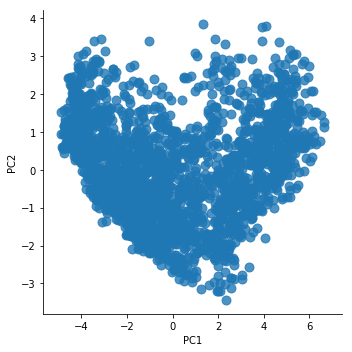

In [79]:
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

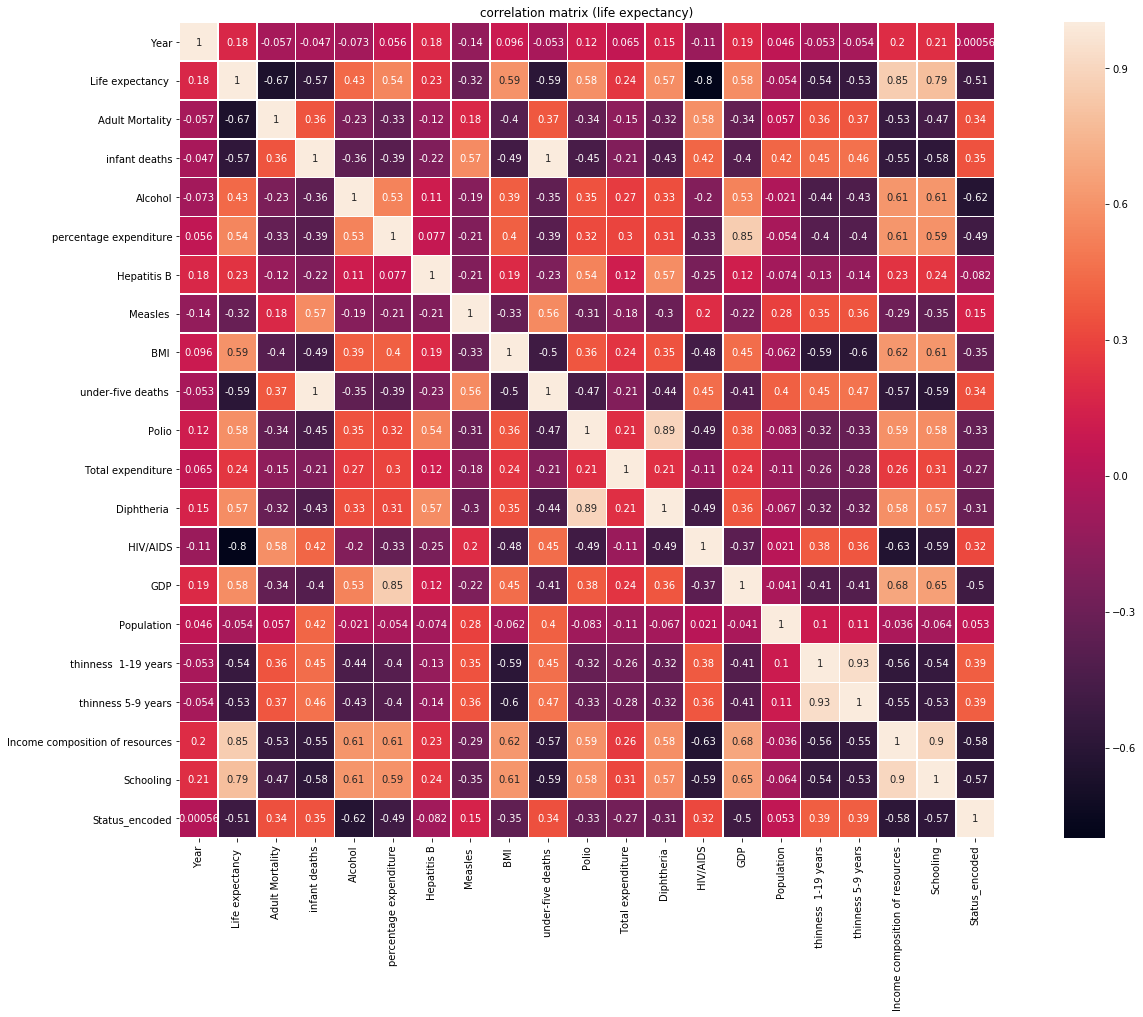

In [53]:
corrmat_student = lifeexpectancy_normal.corr()

plt.figure(figsize=(25,15))

sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (life expectancy)")

plt.show()